<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/NLPfindOffensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a great example of how ML can be used for the greater good.

In this exercise, I will combine NLP (Doc2Vec) with binary classification to extract offensive and hate language from a set of tweets.

Doc2Vec is chosen in this case because it is not pretrained, so it does not rely on a previously provided vocabulary (who knows what we might find... and the tweets are filled with typos, etc). Doc2Vec is a good tool because: 1) as I say does not rely on pre-defined vocabulary and 2) it is a "complete" model, it considers the word in the context of its sentence, gives more accurate results than simpler vectorization tools like TF-IDF.

In [ ]:
import numpy as np
import pandas as pd
import json
pd.options.mode.chained_assignment = None
from io import StringIO
from html.parser import HTMLParser
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltkstop = stopwords.words('english')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
snow = SnowballStemmer(language='english')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import resample


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I have uploaded two datasets, one with a list of possibly offensive tweets and another with a list of generic tweets, with them I build the dataset to study.

Also, I am uploading several datasets that I use to clean the data from words that bring no or generic meaning like place names, personal names, etc.

In [ ]:
maindataset = pd.read_csv("labeled_data.csv")
maindataset2 = pd.read_csv("twitter_dataset.csv", encoding = "ISO-8859-1")

countries = pd.read_json("countries.json")
countries["country"] = countries["country"].str.lower()
countries = pd.DataFrame(countries["country"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
countries.columns = ['word']
countries["replacement"] = "xcountryx"

provincies = pd.read_csv("countries_provincies.csv")
provincies1 = provincies[["name"]]
provincies1["name"] = provincies1["name"].str.lower()
provincies1 = pd.DataFrame(provincies1["name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies1.columns = ['word']
provincies1["replacement"] = "xprovincex"
provincies2 = provincies[["name_alt"]]
provincies2["name_alt"] = provincies2["name_alt"].str.lower()
provincies2 = pd.DataFrame(provincies2["name_alt"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies2.columns = ['word']
provincies2["replacement"] = "xprovincex"
provincies3 = provincies[["type_en"]]
provincies3["type_en"] = provincies3["type_en"].str.lower()
provincies3 = pd.DataFrame(provincies3["type_en"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies3.columns = ['word']
provincies3["replacement"] = "xsubdivisionx"
provincies4 = provincies[["admin"]]
provincies4["admin"] = provincies4["admin"].str.lower()
provincies4 = pd.DataFrame(provincies4["admin"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies4.columns = ['word']
provincies4["replacement"] = "xcountryx"
provincies5 = provincies[["geonunit"]]
provincies5["geonunit"] = provincies5["geonunit"].str.lower()
provincies5 = pd.DataFrame(provincies5["geonunit"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies5.columns = ['word']
provincies5["replacement"] = "xcountryx"
provincies6 = provincies[["gn_name"]]
provincies6["gn_name"] = provincies6["gn_name"].str.lower()
provincies6 = pd.DataFrame(provincies6["gn_name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
provincies6.columns = ['word']
provincies6["replacement"] = "xcountryx"
provincies = pd.concat([provincies1,provincies2,provincies3,provincies4,provincies5,provincies6], axis=0, ignore_index=True)

currencies = pd.read_json("country-by-currency-name.json")
currencies1 = currencies[["country"]]
currencies1["country"] = currencies1["country"].str.lower()
currencies1 = pd.DataFrame(currencies1["country"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
currencies1.columns = ['word']
currencies1["replacement"] = "xcountryx"
currencies2 = currencies[["currency_name"]]
currencies2["currency_name"] = currencies2["currency_name"].str.lower()
currencies2 = pd.DataFrame(currencies2["currency_name"].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
currencies2.columns = ['word']
currencies2["replacement"] = "xcurrencyx"
currencies = pd.concat([currencies1,currencies2], axis=0, ignore_index=True)

firstnames = pd.read_csv("interall.csv", header=None)
firstnames = firstnames[firstnames[1]>=10000]
firstnames = firstnames[[0]]
firstnames[0] = firstnames[0].str.lower()
firstnames = pd.DataFrame(firstnames[0].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
firstnames.columns = ['word']
firstnames["replacement"] = "xfirstnamex"

lastnames = pd.read_csv("intersurnames.csv", header=None)
lastnames = lastnames[lastnames[1]>=10000]
lastnames = lastnames[[0]]
lastnames[0] = lastnames[0].str.lower()
lastnames = pd.DataFrame(lastnames[0].apply(lambda x: str(x).replace('-',' ').replace('.',' ').replace('_',' ').replace(',',' ').replace(':',' ').split(" ")).explode())
lastnames.columns = ['word']
lastnames["replacement"] = "xlastnamex"

temporaldata = pd.read_csv("temporal.csv")

dictionary = pd.concat([lastnames,temporaldata,firstnames,currencies,provincies,countries], axis=0, ignore_index=True)
dictionary = dictionary.groupby(["word"]).first().reset_index(drop=False)
dictionary = dictionary.dropna()

maindataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


It might be necessary to understand a little the data. From Kaggle:

count
number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)

hate_speech
number of CF users who judged the tweet to be hate speech

offensive_language
number of CF users who judged the tweet to be offensive

neither
number of CF users who judged the tweet to be neither offensive nor non-offensive

class
class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

With that, I will filter out the column for class and keep only two, if at least one user flag the tweet as offensive or hate speech then it is.

In [ ]:
maindataset['hate_speech'] = np.where(maindataset['hate_speech']>0,1,0)
maindataset['offensive_language'] = np.where(maindataset['offensive_language']>0,1,0)

maindataset = maindataset[['hate_speech',	'offensive_language', 'tweet']]
maindataset

,hate_speech,offensive_language,tweet
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...
24778,0,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,0,1,"you've gone and broke the wrong heart baby, an..."
24780,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,0,1,youu got wild bitches tellin you lies


I'll prepare the other dataset (with the clean tweets)

In [ ]:
maindataset2 = maindataset2[['text']]
maindataset2.columns = ['tweet']
maindataset2['hate_speech'] = 0
maindataset2['offensive_language'] = 0
maindataset2 = maindataset2[['hate_speech','offensive_language','tweet']]
maindataset = pd.concat([maindataset,maindataset2], ignore_index=True)
maindataset.describe()

,hate_speech,offensive_language
count,44833.000000,44833.000000
mean,0.111369,0.475275
std,0.314592,0.499394
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


Functions used to clean text:

1) Strip HTML tags
2) Replace words using the dictionay crafted above
3) Remove punctuation, double spaces, etc.

In [ ]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def replace_words(tt, lookp_dict):
 temp = tt.split()
 res = []
 for wrd in temp:
  res.append(lookp_dict.get(wrd, wrd))
 res = ' '.join(res)
 return res

def preprepare(eingang):
 ausgang = strip_tags(eingang)
 ausgang = eingang.lower()
 ausgang = ausgang.replace(u'\xa0', u' ')
 ausgang = re.sub(r'^\s*$',' ',str(ausgang))
 ausgang = ausgang.replace('|', ' ')
 ausgang = ausgang.replace('ï', ' ')
 ausgang = ausgang.replace('»', ' ')
 ausgang = ausgang.replace('¿', '. ')
 ausgang = ausgang.replace('ï»¿', ' ')
 ausgang = ausgang.replace('"', ' ')
 ausgang = ausgang.replace("'", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = ausgang.replace('!', ' ')
 ausgang = ausgang.replace(',', ' ')
 ausgang = ausgang.replace(';', ' ')
 ausgang = ausgang.replace('.', ' ')
 ausgang = ausgang.replace("(", " ")
 ausgang = ausgang.replace(")", " ")
 ausgang = ausgang.replace("{", " ")
 ausgang = ausgang.replace("}", " ")
 ausgang = ausgang.replace("[", " ")
 ausgang = ausgang.replace("]", " ")
 ausgang = ausgang.replace("~", " ")
 ausgang = ausgang.replace("@", " ")
 ausgang = ausgang.replace("#", " ")
 ausgang = ausgang.replace("$", " ")
 ausgang = ausgang.replace("%", " ")
 ausgang = ausgang.replace("^", " ")
 ausgang = ausgang.replace("&", " ")
 ausgang = ausgang.replace("*", " ")
 ausgang = ausgang.replace("<", " ")
 ausgang = ausgang.replace(">", " ")
 ausgang = ausgang.replace("/", " ")
 ausgang = ausgang.replace("\\", " ")
 ausgang = ausgang.replace("`", " ")
 ausgang = ausgang.replace("+", " ")
 ausgang = ausgang.replace("=", " ")
 ausgang = ausgang.replace("_", " ")
 ausgang = ausgang.replace("-", " ")
 ausgang = ausgang.replace(':', ' ')
 ausgang = ausgang.replace('\n', ' ').replace('\r', ' ')
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace(" +", " ")
 ausgang = ausgang.replace('?', ' ')
 ausgang = re.sub('[^a-zA-Z]', ' ', ausgang)
 ausgang = re.sub(' +', ' ', ausgang)
 ausgang = re.sub('\ +', ' ', ausgang)
 ausgang = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ausgang)
 return ausgang


Clean up the dictionary data

In [ ]:
dictionary["word"] = dictionary["word"].apply(lambda x: preprepare(x))
dictionary = dictionary[dictionary["word"] != " "]
dictionary = dictionary[dictionary["word"] != ""]
dictionary = {row['word']: row['replacement'] for index, row in dictionary.iterrows()}

Preparation of the text data to convert: created a new column with the cleaned version of the text. This is what will be converted to vectors. Then I replace the stopwords and words in the dictionary

In [ ]:
maindataset["NLPtext"] = maindataset["tweet"]
maindataset["NLPtext"] = maindataset["NLPtext"].str.lower()
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: preprepare(str(x)))
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: ' '.join([word for word in x.split() if word not in (nltkstop)]))
maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: replace_words(str(x), dictionary))

The last part of preparing the text is stemming (make "studies"="study"). This is done in this case, since anyways I am training the model from scratch. I do this because it is likely that some of the offensive language is not even in pre-trained models

In [ ]:
def steming(sentence):
 words = word_tokenize(sentence)
 singles = [snow.stem(plural) for plural in words]
 oup = ' '.join(singles)
 return oup

maindataset["NLPtext"] = maindataset["NLPtext"].apply(lambda x: steming(x))
maindataset['lentweet'] = maindataset["tweet"].apply(lambda x: len(str(x).split(' ')))
maindataset = maindataset[maindataset['NLPtext'].notna()]
maindataset = maindataset[maindataset['lentweet']>=3]
maindataset = maindataset.reset_index(drop=False)
maindataset

,index,hate_speech,offensive_language,tweet,NLPtext,lentweet
0,0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolov woman complain clean xlastnamex a...,25
1,1,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew boy dat cold tyga dwn bad cuffin dat ...,16
2,2,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt sbabi life ever fuck ...,21
3,3,0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt xprovincex xprovincex xlastnamex viva base ...,9
4,4,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikarobert shit hear might xlastnamex mi...,26
...,...,...,...,...,...,...
44595,44828,0,0,"@lookupondeath ...Fine, and I'll drink tea too...",lookupondeath xlastnamex drink xfirstnamex xla...,10
44596,44829,0,0,Greg Hardy you a good player and all but don't...,xfirstnamex xlastnamex xlastnamex player get f...,21
44597,44830,0,0,You can miss people and still never want to se...,miss xprovincex xlastnamex never want xlastnamex,12
44598,44831,0,0,@bitemyapp i had noticed your tendency to pee ...,bitemyapp notic tendenc pee carpet want say an...,19


Train the model

In [ ]:
trainset = maindataset.sample(frac=1).reset_index(drop=True)
trainset = trainset[(trainset['NLPtext'].str.len() >= 3)]
trainset = trainset.sample(frac=1).reset_index(drop=True)
trainset = trainset[["NLPtext"]]

tagged_data = []
for index, row in trainset.iterrows():
 part = TaggedDocument(words=word_tokenize(row[0]), tags=[str(index)])
 tagged_data.append(part)
model = Doc2Vec(vector_size=350, min_count=3, epochs=50, window=10, dm=1)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")


Model Saved


Vetorize the tweets (convert text to numbers)

In [ ]:
a = []
for index, row in maindataset.iterrows():
 nlptext = row['NLPtext']
 ids = row['index']
 vector = model.infer_vector(word_tokenize(nlptext))
 vector = pd.DataFrame(vector).T
 vector.index = [ids]
 a.append(vector)
textvectors = pd.concat(a)
textvectors


,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
0,0.221199,0.331877,-0.332932,-0.143180,0.114841,0.007604,-0.028700,0.172142,0.211286,-0.021508,...,-0.044028,0.399327,-0.062191,0.351848,0.214919,0.273866,0.014157,0.145514,0.047707,-0.306128
1,-0.082753,0.201246,0.131660,-0.017309,0.080802,-0.241773,0.238145,0.179774,-0.249412,0.107645,...,0.253916,-0.060053,-0.002539,-0.040306,-0.034489,-0.090694,0.198258,0.019001,-0.300919,-0.363364
2,-0.116307,0.433399,0.324086,0.318445,-0.145800,-0.127382,0.077291,-0.133755,0.341922,-0.129767,...,0.005878,-0.085363,-0.320783,-0.267421,0.482514,0.304111,0.159666,-0.138879,0.048530,0.257447
3,0.078409,-0.170744,-0.082416,-0.011689,0.164153,0.079994,-0.085636,0.140649,-0.152805,-0.034392,...,0.215953,0.071021,0.108901,-0.111622,0.123561,-0.029187,0.002183,-0.133840,-0.041305,-0.002318
4,-0.131317,0.112325,0.203133,0.486649,-0.023085,0.232699,-0.020652,0.369451,0.048875,0.029301,...,-0.103153,-0.321159,-0.102373,-0.158022,0.186136,0.044516,0.082313,-0.274851,0.053601,-0.117965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44828,-0.005884,-0.057826,0.057261,-0.045232,0.084563,-0.029124,0.025663,0.153593,-0.024561,-0.087083,...,0.070761,-0.013762,-0.028703,-0.144167,0.137005,-0.043255,0.073634,0.072506,-0.001655,0.024982
44829,-0.106896,-0.152507,-0.056599,-0.145463,0.152959,0.138858,-0.071907,0.096140,0.060623,-0.016229,...,-0.085106,-0.153142,0.155456,0.063890,0.068109,-0.115918,0.195273,-0.009219,0.115154,0.085780
44830,-0.077903,-0.237636,-0.242578,0.083256,0.086112,0.162927,0.188774,0.395371,-0.097747,-0.158647,...,0.014706,0.000956,-0.039480,-0.094244,0.067050,0.099072,-0.069785,-0.136884,0.081011,-0.087794
44831,-0.003358,0.014248,-0.004664,0.160442,-0.045702,0.046280,0.079180,0.257364,-0.049503,-0.121967,...,0.098091,-0.123507,-0.082751,-0.153656,0.142996,-0.088888,-0.099935,-0.178297,-0.057791,0.008529


Standarization

In [ ]:
def properscaler(simio):
 scaler = StandardScaler()
 resultsWordstrans = scaler.fit_transform(simio)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = simio.columns
 return resultsWordstrans

datasetR = properscaler(textvectors)

I'll split in train and test sets (on offensive language)

In [ ]:
datasetR['target'] = maindataset['offensive_language'].values

outp = train_test_split(datasetR, train_size=0.7)
finaleval=outp[1]
subset=outp[0]

x_subset = subset.drop(columns=["target"]).to_numpy()
y_subset = subset['target'].to_numpy()
x_finaleval = finaleval.drop(columns=["target"]).to_numpy()
y_finaleval = finaleval[['target']].to_numpy()
#size of the training set
len(y_subset)

31219

The distribution of the response is relevant to select the activation functions used in the neural network

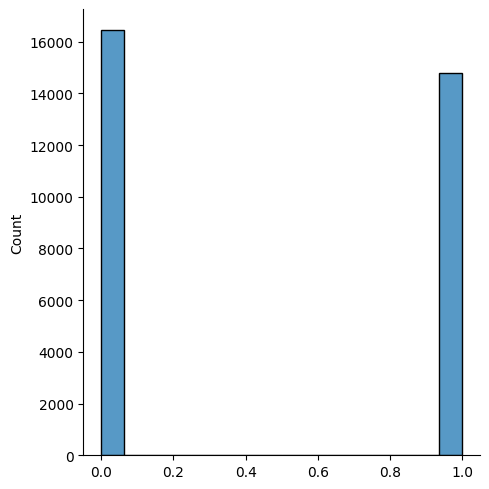

In [ ]:
sns.displot(y_subset)

Definitions for the neural network model using Tensorflow / keras. A sigmoid is selected as the final function since it is the selected outcome of a binary classification (the function tends to 0 or 1).

In [ ]:
#initialize
neur = tf.keras.models.Sequential()
#layers
neur.add(tf.keras.layers.Dense(units=100, activation='linear'))
neur.add(tf.keras.layers.Dense(units=200, activation='relu'))
neur.add(tf.keras.layers.Dense(units=500, activation='tanh'))

#output layer
neur.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#using cross entropy as loss function, sigmoid for optimizer and recall and precision for binary classification
neur.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])


Train the model

In [ ]:
neur.fit(x_subset, y_subset, batch_size=20000, epochs=700)

Epoch 1/700
2/2 [==============================] - 1s 230ms/step - loss: 0.4528 - precision: 0.7990 - recall: 0.7790
Epoch 2/700
2/2 [==============================] - 1s 222ms/step - loss: 0.4521 - precision: 0.7988 - recall: 0.7797
Epoch 3/700
2/2 [==============================] - 1s 230ms/step - loss: 0.4514 - precision: 0.7990 - recall: 0.7803
Epoch 4/700
2/2 [==============================] - 1s 227ms/step - loss: 0.4507 - precision: 0.7991 - recall: 0.7805
Epoch 5/700
2/2 [==============================] - 1s 230ms/step - loss: 0.4500 - precision: 0.7993 - recall: 0.7805
Epoch 6/700
2/2 [==============================] - 1s 217ms/step - loss: 0.4493 - precision: 0.7996 - recall: 0.7815
Epoch 7/700
2/2 [==============================] - 1s 217ms/step - loss: 0.4487 - precision: 0.8000 - recall: 0.7820
Epoch 8/700
2/2 [==============================] - 1s 227ms/step - loss: 0.4480 - precision: 0.7999 - recall: 0.7831
Epoch 9/700
2/2 [==============================] - 1s 213ms/step

We see on the last steps that the precision and recall are not improving anymore, so we are sure the model has done everything it can do at this point. Now I evaluate the test set.

In [ ]:
test_out = neur.predict(x_finaleval)
test_out

419/419 [==============================] - 1s 2ms/step


array([[0.4310239 ],
       [0.93514055],
       [0.18660098],
       ...,
       [0.9413881 ],
       [0.03979347],
       [0.8253069 ]], dtype=float32)

Final result (Offensive language)

In [ ]:
output = outp[1][[0]]
scal = MinMaxScaler()
output['predicted'] = scal.fit_transform(test_out)
output['actual'] = y_finaleval
output = output.drop(columns=[0])
output = pd.merge(output, maindataset[['index','tweet']], left_index=True, right_on=['index'])
output = output.sort_values(['predicted'], ascending=False)
pd.options.display.max_colwidth = 150
output

,predicted,actual,index,tweet
15222,9.999999e-01,1,15384,"RT @GrownAssMidget: I&#8217;m a bitch? You&#8217;re a bitch. Your mom&#8217;s a bitch for having a bitch, your dad&#8217;s a bitch for fucking a b..."
13159,9.999971e-01,1,13315,Niggas be bitches hoes be bitches ion see no difference
478,9.999969e-01,1,478,"""I had a bitch that had a bitch, had the bitch eating halibut.."" - @iamyoungroc #FreshRhymes #JerkSquad #SlowStir"
18073,9.999919e-01,1,18235,RT @_2kkz: This faggit bitch tried to say she hoe'd for hd bearfaced bitch yusa fag
10802,9.999889e-01,1,10945,I tell the 5th bitch to get the 6th bitch to to have the 7th bitch bring more.
...,...,...,...,...
27143,6.846691e-05,0,27362,ÛÏPoetry is eternal graffiti written in the heart of everyone.Û https://t.co/Lj4WLpgmPm
33819,5.055554e-05,0,34041,the third chapter of head over heels has been updated! https://t.co/uYAVU6QH1X
35521,1.446507e-05,0,35748,General Mills - Source Greek Snack Bowl - 12g Of Protein And 50% ... - https://t.co/6T7KOKBVUn - #tvcommercialspots https://t.co/j4DdX6PLve
30979,1.954322e-07,0,31200,Skyscrapers are NOT ruining the London skyline claims The Shard architect Renzo Piano #UkNews https://t.co/AOWVgTUFk3


Confusion Matrix (cut point at 0.5)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      7034
           1       0.86      0.83      0.84      6347

    accuracy                           0.85     13381
   macro avg       0.85      0.85      0.85     13381
weighted avg       0.85      0.85      0.85     13381



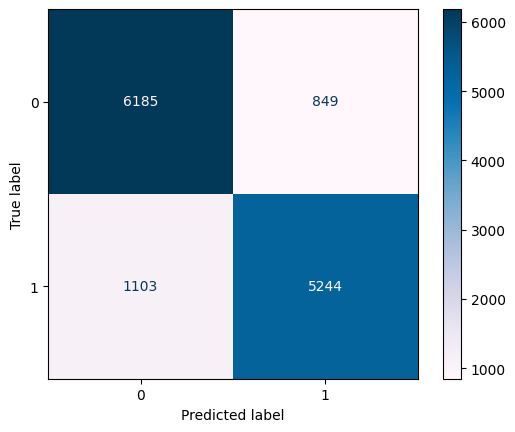

In [ ]:
output["predictedVal"] = np.where(output['predicted']>=0.5,1,0)
print(classification_report(output['actual'],output["predictedVal"] ))
ConfusionMatrixDisplay.from_predictions(y_true=output['actual'] ,y_pred=output['predictedVal'] , cmap='PuBu')

Using the same approach now for hate speech:

31219


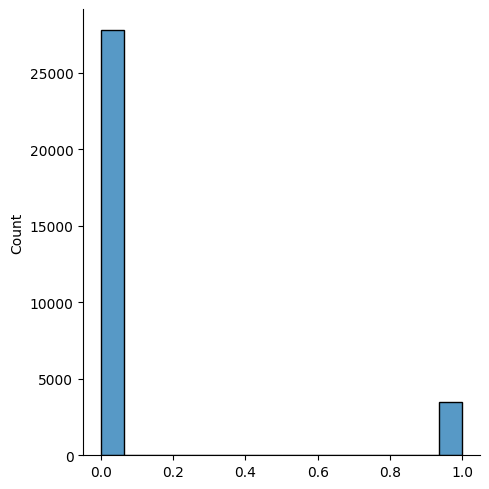

In [ ]:
datasetR['target'] = maindataset['hate_speech'].values

outp = train_test_split(datasetR, train_size=0.7)
finaleval=outp[1]
subset=outp[0]

x_subset = subset.drop(columns=["target"]).to_numpy()
y_subset = subset['target'].to_numpy()
x_finaleval = finaleval.drop(columns=["target"]).to_numpy()
y_finaleval = finaleval[['target']].to_numpy()
#size of the training set
print(len(y_subset))
sns.displot(y_subset)




The classes are highly unbalanced, the next step is used to rebalance the classes

12000


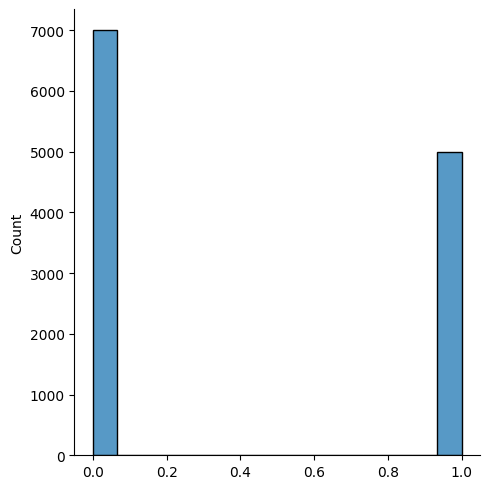

In [ ]:
def rebalance(sset, min, max):
 classes = list(set(sset["target"]))
 a = []
 for clas in classes:
  positives = sset[sset['target']==clas]
  if len(positives) < min:
   positives = resample(positives, n_samples=min, replace=True)
  if len(positives) > max:
   positives = resample(positives, n_samples=max, replace=False)
  a.append(positives)
 rebalanced = pd.concat(a, axis=0, ignore_index=True)
 return rebalanced

subsetR = rebalance(sset=subset, min=round(5000), max=round(7000))

x_subset = subsetR.drop(columns=["target"]).to_numpy()
y_subset = subsetR['target'].to_numpy()
print(len(y_subset))
sns.displot(y_subset)

In [ ]:
#initialize
neur = tf.keras.models.Sequential()
#layers
neur.add(tf.keras.layers.Dense(units=100, activation='linear'))
neur.add(tf.keras.layers.Dense(units=200, activation='relu'))
neur.add(tf.keras.layers.Dense(units=500, activation='tanh'))

#output layer
neur.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#using mse for regression. Simple and clear
neur.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

neur.fit(x_subset, y_subset, batch_size=10000, epochs=700)

Epoch 1/700
2/2 [==============================] - 1s 49ms/step - loss: 0.7491 - precision_6: 0.3953 - recall_6: 0.5716
Epoch 2/700
2/2 [==============================] - 0s 49ms/step - loss: 0.7331 - precision_6: 0.4023 - recall_6: 0.4904
Epoch 3/700
2/2 [==============================] - 0s 48ms/step - loss: 0.7224 - precision_6: 0.4123 - recall_6: 0.4328
Epoch 4/700
2/2 [==============================] - 0s 58ms/step - loss: 0.7147 - precision_6: 0.4238 - recall_6: 0.3896
Epoch 5/700
2/2 [==============================] - 0s 47ms/step - loss: 0.7085 - precision_6: 0.4319 - recall_6: 0.3570
Epoch 6/700
2/2 [==============================] - 0s 50ms/step - loss: 0.7035 - precision_6: 0.4443 - recall_6: 0.3516
Epoch 7/700
2/2 [==============================] - 0s 49ms/step - loss: 0.6988 - precision_6: 0.4529 - recall_6: 0.3454
Epoch 8/700
2/2 [==============================] - 0s 47ms/step - loss: 0.6944 - precision_6: 0.4665 - recall_6: 0.3440
Epoch 9/700
2/2 [=======================

In [ ]:
test_out = neur.predict(x_finaleval)
output2 = outp[1][[0]]
scal = MinMaxScaler()
output2['predicted'] = scal.fit_transform(test_out)
output2['actual'] = y_finaleval
output2 = output2.drop(columns=[0])
output2 = pd.merge(output2, maindataset[['index','tweet']], left_index=True, right_on=['index'])
output2 = output2.sort_values(['predicted'], ascending=False)
pd.options.display.max_colwidth = 150
output2

419/419 [==============================] - 1s 2ms/step


,predicted,actual,index,tweet
6098,1.000000,1,6189,@itsjustmexo ur a cunt nd a wish a was a faggot
5415,0.999650,1,5486,@alesiahenderson wat a faggot
18974,0.999496,1,19136,RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.
12492,0.999495,1,12643,"Look at this little faggot.\n""@Kellz622: Tell her she's beautiful as much as you can. It'll make her smile"""
9353,0.999464,0,9490,Good day spent with my faggot
...,...,...,...,...
33420,0.000600,0,33641,BUY MARIJUANA SEEDS: Revealed: The 10 Manchester bus lanes most likely to catch out drivers... https://t.co/MqRmtEb3cr #manchester #leeds
35432,0.000500,0,35659,"Love this journal, lots of thoughtful articles and treasure! #tlchat #OZTL https://t.co/co8SCzzAp4"
26392,0.000284,0,26611,"Just when you thought #TRFC had plumbed the depths of woeful cup draws...boom, Whitehawk away! https://t.co/mfxCOlLZ58"
42794,0.000268,0,43026,When u want something so badly that everything else fades away and that one thing is your entire world... You know you will succeed


              precision    recall  f1-score   support

           0       0.94      0.83      0.88     11920
           1       0.31      0.60      0.41      1461

    accuracy                           0.81     13381
   macro avg       0.62      0.72      0.64     13381
weighted avg       0.87      0.81      0.83     13381



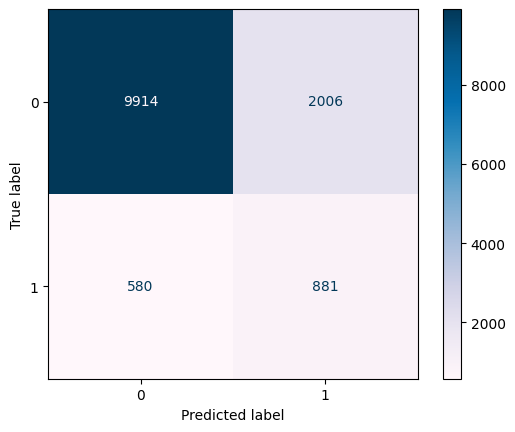

In [ ]:
output2["predictedVal"] = np.where(output2['predicted']>=0.5,1,0)
print(classification_report(output2['actual'],output2["predictedVal"] ))
ConfusionMatrixDisplay.from_predictions(y_true=output2['actual'] ,y_pred=output2['predictedVal'] , cmap='PuBu')